In [362]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import hockey_rink
import hockey_scraper
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

Gonna get familiar with hockey_scraper, never used it until now. Scraping the schedule between 2023-09-01 and 2024-08-31. Should be 1,312 NHL games in a season.

In [ ]:
hockey_scraper.scrape_seasons([2023,2024], True)

Noe have shift data for the nhl 2023-24 season as well as the play by play data (pbp) in separate csv files. 

In [363]:
#Loading in pbp data
pbp=pd.read_csv("nhl_pbp_20232024.csv")

How many rows in our dataframe total?
-445,637 rows before we do any type of manipulation or cleaning
-After dropping rows that contain na values for x and y locations, we have 323,164 rows
-

In [364]:
pbp.info()
#445,637 events worth of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445637 entries, 0 to 445636
Data columns (total 57 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       445637 non-null  int64  
 1   Game_Id          445637 non-null  int64  
 2   Date             445637 non-null  object 
 3   Period           445637 non-null  int64  
 4   Event            445637 non-null  object 
 5   Description      445637 non-null  object 
 6   Time_Elapsed     445637 non-null  object 
 7   Seconds_Elapsed  445637 non-null  float64
 8   Strength         445637 non-null  object 
 9   Ev_Zone          369193 non-null  object 
 10  Type             180765 non-null  object 
 11  Ev_Team          369085 non-null  object 
 12  Home_Zone        369193 non-null  object 
 13  Away_Team        445637 non-null  object 
 14  Home_Team        445637 non-null  object 
 15  p1_name          369011 non-null  object 
 16  p1_ID            360845 non-null  floa

In [365]:
# Drop rows where xC or yC is NaN
pbp = pbp.dropna(subset=['xC', 'yC'])
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323164 entries, 1 to 445636
Data columns (total 57 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       323164 non-null  int64  
 1   Game_Id          323164 non-null  int64  
 2   Date             323164 non-null  object 
 3   Period           323164 non-null  int64  
 4   Event            323164 non-null  object 
 5   Description      323164 non-null  object 
 6   Time_Elapsed     323164 non-null  object 
 7   Seconds_Elapsed  323164 non-null  float64
 8   Strength         323164 non-null  object 
 9   Ev_Zone          270144 non-null  object 
 10  Type             139605 non-null  object 
 11  Ev_Team          270069 non-null  object 
 12  Home_Zone        270144 non-null  object 
 13  Away_Team        323164 non-null  object 
 14  Home_Team        323164 non-null  object 
 15  p1_name          270001 non-null  object 
 16  p1_ID            263648 non-null  float64
 

In [38]:
#Loading in shift data
shifts=pd.read_csv("nhl_shifts_20232024.csv")

Step 2: Data Cleansing

Definitely do not need many of these variables so going to drop a bunch of them

In [366]:
pbp[['awayPlayer1','awayPlayer2', 'awayPlayer3','awayPlayer4','awayPlayer5','awayPlayer6']].head(10)

,awayPlayer1,awayPlayer2,awayPlayer3,awayPlayer4,awayPlayer5,awayPlayer6
1,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,RYAN MCDONAGH,ALEXANDRE CARRIER,JUUSE SAROS
2,YAKOV TRENIN,RYAN O'REILLY,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
4,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
5,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
6,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
7,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE SCHENN,ROMAN JOSI,JUUSE SAROS
8,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,JEREMY LAUZON,TYSON BARRIE,JUUSE SAROS
9,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,JEREMY LAUZON,TYSON BARRIE,JUUSE SAROS
10,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,JEREMY LAUZON,TYSON BARRIE,JUUSE SAROS
11,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,JEREMY LAUZON,TYSON BARRIE,JUUSE SAROS


Alright looks like players 1,2, and 3 are the forwards. 4 and 5 are the defensemen and 6 is the goalie, So i only need players 1-3

In [367]:
pbp=pbp.drop(['Away_Coach','Home_Coach','Home_Goalie_Id','Home_Goalie','Away_Goalie_Id','Away_Goalie', 'Unnamed: 0','awayPlayer4','awayPlayer4_id','awayPlayer5','awayPlayer5_id','awayPlayer6','awayPlayer6_id','homePlayer4','homePlayer4_id','homePlayer5','homePlayer5_id','homePlayer6','homePlayer6_id'], axis=1)

In [368]:
pbp.Type.value_counts()

Type
WRIST SHOT                              77163
SNAP SHOT                               18419
SLAP SHOT                               16066
TIP-IN                                   9190
BACKHAND                                 8148
                                        ...  
AR #77 DEANGELO Slashing(2 min)             1
OS #61 MAROON High-sticking(2 min)          1
AL #3 TANEV Delay Game(2 min)               1
AL #3 TANEV High-sticking(2 min)            1
YR #96 ROSLOVIC High-sticking(2 min)        1
Name: count, Length: 204, dtype: int64

Got rid of a ton of columns not needed. All columns now should be useful

In [369]:
pbp.columns

Index(['Game_Id', 'Date', 'Period', 'Event', 'Description', 'Time_Elapsed',
       'Seconds_Elapsed', 'Strength', 'Ev_Zone', 'Type', 'Ev_Team',
       'Home_Zone', 'Away_Team', 'Home_Team', 'p1_name', 'p1_ID', 'p2_name',
       'p2_ID', 'p3_name', 'p3_ID', 'awayPlayer1', 'awayPlayer1_id',
       'awayPlayer2', 'awayPlayer2_id', 'awayPlayer3', 'awayPlayer3_id',
       'homePlayer1', 'homePlayer1_id', 'homePlayer2', 'homePlayer2_id',
       'homePlayer3', 'homePlayer3_id', 'Away_Players', 'Home_Players',
       'Away_Score', 'Home_Score', 'xC', 'yC'],
      dtype='object')

Variables we want, many of which need to be modified or created:

    1)xC (modified) (Done)

    2)yC (Modified) (Done)

    3)Type (modified) (Done)

    4)shotDistance (Create)

    5)shotAngle (Create)

    6)timeSinceLastEvent (Create) (Done)

    7)distanceFromLastEvent (Create) (Have to calculate before transposing the x and y coordinates, cuz what if back to back shots happen between the two teams?) (Done)

    8)PowerPlay (Create) (Done)

    9) Goal (Create) - TARGET VARIABLE (Done)

-Date needs to be last of reg season, not last of entire season including playoffs

Calculating the distanceFromLastEvent prior to transposing x and y coordinates

In [370]:
# Calculate the difference in x and y coordinates between consecutive events
pbp['x_diff'] = pbp['xC'].diff()
pbp['y_diff'] = pbp['yC'].diff()

# Calculate the Euclidean distance between consecutive events
pbp['distanceFromLastEvent'] = np.sqrt(pbp['x_diff']**2 + pbp['y_diff']**2)

# Fill NaN values that may result from the first row
pbp['distanceFromLastEvent'] = pbp['distanceFromLastEvent'].fillna(0)

# Optionally, drop the intermediate x_diff and y_diff columns if no longer needed
pbp = pbp.drop(columns=['x_diff', 'y_diff'])

Making all shots occur on the right side of the rink, modifying the xC and yC

In [371]:
#First making all shots appear on the positive (right side of the rink)
pbp['xC']=np.where(pbp['xC']<0, pbp['xC']*-1, pbp['xC'])
pbp['yC']=np.where(pbp['xC']<0, pbp['yC']*-1, pbp['yC'])

Making new column for PowerPlay, 1 means yes there is a pp and 0 means no pp

In [372]:
# Make a new column for whether or not its a power play goal. 
pbp['Power Play'] = np.where( ((pbp.Ev_Team.equals(pbp.Home_Team)) & (pbp.Strength.str[0] > pbp.Strength.str[2])) | ((pbp.Ev_Team.equals(pbp.Away_Team)) & (pbp.Strength.str[0] < pbp.Strength.str[2])), 1, 0)

Getting time since last event (Right now have seconds elapsed, which is just time elapsed from period. So to get time elapsed since last event, Just have to subtract seconds elased on previous row/event from the current row/event)

In [373]:
pbp['timeSinceLastEvent']= pbp['Seconds_Elapsed'].diff()
pbp['timeSinceLastEvent'] = pbp['timeSinceLastEvent'].fillna(0)


Make the each shot type into individual binary value columns using one hot encoding (Then keeping the columns created that represents shots only: WRIST SHOT,SNAP SHOT,SLAP SHOT,TIP-IN,BACKHAND, Done at the very end of data cleaning)

In [374]:
dtype = pbp['Type'].dtype
print(dtype)

object


In [375]:
pbp['Type'].value_counts()

Type
WRIST SHOT                              77163
SNAP SHOT                               18419
SLAP SHOT                               16066
TIP-IN                                   9190
BACKHAND                                 8148
                                        ...  
AR #77 DEANGELO Slashing(2 min)             1
OS #61 MAROON High-sticking(2 min)          1
AL #3 TANEV Delay Game(2 min)               1
AL #3 TANEV High-sticking(2 min)            1
YR #96 ROSLOVIC High-sticking(2 min)        1
Name: count, Length: 204, dtype: int64

Im going to keep only the values of type above not any other crazy ones. I am also going to convert to string.

In [376]:
pbp['Type'] = pbp['Type'].astype(str)
pbp=pbp[(pbp['Type']=='WRIST SHOT') | (pbp['Type']=='SNAP SHOT') | (pbp['Type']=='SLAP SHOT') | (pbp['Type']=='TIP-IN') | (pbp['Type']=='BACKHAND') | (pbp['Type']=='DEFLECTED') | (pbp['Type']=='WRAP-AROUND') ]

In [377]:
#checking 
pbp['Type'].value_counts()

Type
WRIST SHOT     77163
SNAP SHOT      18419
SLAP SHOT      16066
TIP-IN          9190
BACKHAND        8148
DEFLECTED       2074
WRAP-AROUND      919
Name: count, dtype: int64

In [378]:
# Ensure the Type column is clean (e.g., no leading/trailing spaces)
pbp['Type'] = pbp['Type'].str.strip()

# Identify unique categories
unique_types = pbp['Type'].unique()

# Manually one-hot encode
for shot_type in unique_types:
    pbp[shot_type] = (pbp['Type'] == shot_type).astype(int)

Code below for ohe not working, trying the above approach instead

In [344]:
# #First step load in one hot encoder from the sklearn.preprocessing library
# from sklearn.preprocessing import OneHotEncoder
# # Ensure there are no NaNs in the 'Type' column
# pbp = pbp.dropna(subset=['Type'])
# #Second step is to initialize OneHotEncoder
# ohe=OneHotEncoder(sparse_output=False, drop='first')
# #Third step is to fit and transform
# pbp_ohe=ohe.fit_transform(pbp[['Type']])
# #Fourth step is to conver the output to a datafram with the appropriate column names
# pbp_df_ohe=pd.DataFrame(pbp_ohe, columns=ohe.get_feature_names_out(['Type']))
# #Fifth step is to combine the encoded shotType columns with the original dataframe
# pbp=pd.concat([pbp, pbp_df_ohe], axis=1)

In [345]:
# print(ohe.get_feature_names_out(['Type']))

['Type_DEFLECTED' 'Type_SLAP SHOT' 'Type_SNAP SHOT' 'Type_TIP-IN'
 'Type_WRAP-AROUND' 'Type_WRIST SHOT']


In [379]:
#Checking columns
pbp.columns

Index(['Game_Id', 'Date', 'Period', 'Event', 'Description', 'Time_Elapsed',
       'Seconds_Elapsed', 'Strength', 'Ev_Zone', 'Type', 'Ev_Team',
       'Home_Zone', 'Away_Team', 'Home_Team', 'p1_name', 'p1_ID', 'p2_name',
       'p2_ID', 'p3_name', 'p3_ID', 'awayPlayer1', 'awayPlayer1_id',
       'awayPlayer2', 'awayPlayer2_id', 'awayPlayer3', 'awayPlayer3_id',
       'homePlayer1', 'homePlayer1_id', 'homePlayer2', 'homePlayer2_id',
       'homePlayer3', 'homePlayer3_id', 'Away_Players', 'Home_Players',
       'Away_Score', 'Home_Score', 'xC', 'yC', 'distanceFromLastEvent',
       'Power Play', 'timeSinceLastEvent', 'WRIST SHOT', 'TIP-IN', 'SNAP SHOT',
       'SLAP SHOT', 'BACKHAND', 'DEFLECTED', 'WRAP-AROUND'],
      dtype='object')

Dropping shots from behind the net

In [380]:
pbp.drop(pbp[pbp['xC'] > 89].index, inplace=True)

Getting goals column

In [381]:
# Add a binary column for Goals 
pbp['goal'] = np.where(pbp.Event == 'GOAL', 1, 0)

In [382]:
pbp['goal'].value_counts()

goal
0    114067
1      6846
Name: count, dtype: int64

In [383]:
pbp['Event'].value_counts()

Event
SHOT     59390
BLOCK    30792
MISS     23885
GOAL      6846
Name: count, dtype: int64

We can drop all rows where event is not equal to shot or goal because we already calculated the distance from last event and the time since last event which were the variables that needed to have every event in the dataframe. 

In [384]:
pbp=pbp[(pbp['Event']=='SHOT') | (pbp['Event']=='GOAL') | (pbp['Event']=='MISS')]

In [385]:
#Seeing the pbp dataframe
pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC']].head(10)

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,homePlayer3,Description,Strength,Seconds_Elapsed,timeSinceLastEvent,goal,distanceFromLastEvent,Power Play,xC,yC
6,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",5x5,61.0,3.0,0,26.019224,0,44.0,-38.0
40,Off,T.B,T.B,NSH,SHOT,PHILIP TOMASINO,RYAN O'REILLY,LUKE EVANGELISTA,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",5x5,564.0,4.0,0,56.142675,0,55.0,30.0
41,Off,T.B,T.B,NSH,GOAL,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",5x5,588.0,24.0,1,119.067208,0,64.0,34.0
44,Neu,T.B,T.B,NSH,MISS,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,BRANDON HAGEL,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",5x5,603.0,15.0,0,72.422372,0,69.0,22.0
47,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,TANNER JEANNOT,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",5x5,615.0,9.0,0,50.009999,0,79.0,-27.0
49,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,TANNER JEANNOT,"TBL ONGOAL - #11 GLENDENING, Wrist , Off. Zone...",5x5,637.0,19.0,0,68.883960,0,31.0,30.0
53,Off,T.B,T.B,NSH,SHOT,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,"TBL ONGOAL - #21 POINT, Wrist , Off. Zone, 15 ...",5x5,662.0,10.0,0,21.095023,0,69.0,-22.0
57,Off,T.B,T.B,NSH,SHOT,CODY GLASS,PHILIP TOMASINO,KIEFER SHERWOOD,MICHAEL EYSSIMONT,NICHOLAS PAUL,CONOR SHEARY,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 54...",5x5,693.0,23.0,0,77.278716,0,7.0,-36.0
61,Off,T.B,T.B,NSH,SHOT,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,BRANDON HAGEL,"TBL ONGOAL - #38 HAGEL, Snap , Off. Zone, 30 ft.",5x5,708.0,9.0,0,108.337436,0,69.0,-22.0
68,Off,T.B,T.B,NSH,MISS,GUSTAV NYQUIST,PHILIP TOMASINO,JUUSO PARSSINEN,WALTTERI MERELA,NICHOLAS PAUL,CALVIN DE HAAN,"TBL #20 PAUL, Snap, Wide Left, Off. Zone, 28 ft.",4x5,795.0,6.0,0,44.000000,0,69.0,-22.0


Ok, lets get a sense on where out dataframe is at, how many rows contain na values for the x and y coordinates?

In [386]:
# Count the number of NaN values in the xC and yC columns
xC_nan_count = pbp['xC'].isna().sum()
yC_nan_count = pbp['yC'].isna().sum()

# Print the counts
print(f"Number of NaN values in xC: {xC_nan_count}")
print(f"Number of NaN values in yC: {yC_nan_count}")

Number of NaN values in xC: 0
Number of NaN values in yC: 0


How many total values are in our dataframe?

In [387]:
pbp.shape

(90121, 49)

Getting shot angles using a function

In [388]:
# This function calculates the angle to the center of the net at (89, 0) in radians and degrees.
def angles(x, y):
    num = math.sqrt(((89.0 - x) * (89.0 - x)) + ((y) * (y)))
    if num==0:
        radians= 0.0
        degrees= 0.0
    else:
        radians = np.arcsin(y/num)
        degrees = (radians * 180.0) / 3.14
        
    arr = [radians, degrees]
    return arr

Now using that function to place angles into dataframe and also get shot distance

In [389]:
# Initiliaze empty columns
pbp['shotAngle_Radians'] = ''
pbp['shotAngle_Degrees'] = ''
pbp['shotDistance'] = ''

# Add values to columns 
for index, row in pbp.iterrows():
    x = row['xC']
    y = row['yC']
    all_angles = angles(x, y)
    pbp.at[index, 'shotAngle_Radians'] = all_angles[0]
    pbp.at[index, 'shotAngle_Degrees'] = all_angles[1]
    pbp.at[index, 'shotDistance'] = np.sqrt((y - 0)**2 + (x - 89.0)**2)

Now we should have all variables, lets see if it worked

In [390]:
pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Radians','shotAngle_Degrees','shotDistance']].head(10)

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,...,Seconds_Elapsed,timeSinceLastEvent,goal,distanceFromLastEvent,Power Play,xC,yC,shotAngle_Radians,shotAngle_Degrees,shotDistance
6,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,BRAYDEN POINT,STEVEN STAMKOS,...,61.0,3.0,0,26.019224,0,44.0,-38.0,-0.70126,-40.199613,58.898217
40,Off,T.B,T.B,NSH,SHOT,PHILIP TOMASINO,RYAN O'REILLY,LUKE EVANGELISTA,BRAYDEN POINT,STEVEN STAMKOS,...,564.0,4.0,0,56.142675,0,55.0,30.0,0.722979,41.444676,45.343136
41,Off,T.B,T.B,NSH,GOAL,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,BRAYDEN POINT,STEVEN STAMKOS,...,588.0,24.0,1,119.067208,0,64.0,34.0,0.936774,53.700398,42.201896
44,Neu,T.B,T.B,NSH,MISS,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,...,603.0,15.0,0,72.422372,0,69.0,22.0,0.832981,47.750518,29.732137
47,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,...,615.0,9.0,0,50.009999,0,79.0,-27.0,-1.216091,-69.712204,28.79236
49,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,...,637.0,19.0,0,68.883960,0,31.0,30.0,0.477345,27.363748,65.299311
53,Off,T.B,T.B,NSH,SHOT,CODY GLASS,GUSTAV NYQUIST,KIEFER SHERWOOD,BRAYDEN POINT,STEVEN STAMKOS,...,662.0,10.0,0,21.095023,0,69.0,-22.0,-0.832981,-47.750518,29.732137
57,Off,T.B,T.B,NSH,SHOT,CODY GLASS,PHILIP TOMASINO,KIEFER SHERWOOD,MICHAEL EYSSIMONT,NICHOLAS PAUL,...,693.0,23.0,0,77.278716,0,7.0,-36.0,-0.413689,-23.714668,89.554453
61,Off,T.B,T.B,NSH,SHOT,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,...,708.0,9.0,0,108.337436,0,69.0,-22.0,-0.832981,-47.750518,29.732137
68,Off,T.B,T.B,NSH,MISS,GUSTAV NYQUIST,PHILIP TOMASINO,JUUSO PARSSINEN,WALTTERI MERELA,NICHOLAS PAUL,...,795.0,6.0,0,44.000000,0,69.0,-22.0,-0.832981,-47.750518,29.732137


Last step is to limit games to only regular season games. Last day of the regular season was 04-18. Get rid of all rows with a date after that. 

In [391]:
dtype = pbp['Date'].dtype
print(dtype)

object


In [392]:
pbp['Date'].tail()

445623    2024-06-24
445626    2024-06-24
445627    2024-06-24
445628    2024-06-24
445634    2024-06-24
Name: Date, dtype: object

Alright to accomplish getting rid of playoff data, have to convert the date column to datetime format, and then filter for rows before 2024-04-18

In [393]:
# Convert 'date' column to datetime format
pbp['Date'] = pd.to_datetime(pbp['Date'])

# Define the cutoff date
cutoff_date = pd.to_datetime('2024-04-18')

# Filter rows where the date is after the cutoff date
pbp = pbp[pbp['Date'] <= cutoff_date]

Alright now to only keep the variables we want. Dropping all other columns. Then our data should be good to go for modeling!!

Shot types:  'WRIST SHOT', 'TIP-IN', 'SNAP SHOT',
       'SLAP SHOT', 'BACKHAND', 'DEFLECTED', 'WRAP-AROUND'

In [394]:
pbp=pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Radians','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT','Description','Type']]

Alright, now that we got rid of a good number of columns we don't need, let's think about the problem at hand. I want to evaluate who are the best 20 forward lines in the nhl. How should I accomplish this? I think the best way from a hollistic standpoint is expected goals %. Expected Goals % is the percent of all expected goals the player's team gets while the player is on the ice compared to the other team. For example, if a player's team gets 0.6 expected goals and the opposing team gets 0.4 expected goals while the player is on the ice, the player's expected goals % is 60%. 

On MoneyPuck, an xGoals% of above 60% gets a forward line inside the top 10 (Limiting to lines who played 200 minutes or more together).An xGoals% of 50% and above gets a FL inside the top 60 lines. 

I also want to look at each lines expected goals against and their expected goals for, rather than the percentage of expected goal they own. An expected goals for of 28 or above gets you in the top 10, and an xG For of 20 gets you inside the top 25. 

For xG against, 8.5 or less gets you inside the top 10, 11 or less gets you inside the top 25. 

By looking at these xG for and xG against rather than xG%, I can get the best offensive forward lines and the best defensive lines.

Thus, at the very end of this project my goal is to have 3 different rankings:
1) The best 15 lines in hockey (using xG%)
2) The best 15 offensive lines in hockey (using xG For)
3) The best 15 defensive lines in hockey (using xG Against)

Step 3: Building the model and features to be passed into the model

pbp=pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Radians','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT','Description','Type']]

Alright, in the expected goals model I am building, these variables will be features with variable 15 being the target:
    1)xC
    2)yC
    3)BACKHAND
    4)DEFLECTED
    5)SLAP SHOT
    6)SNAP SHOT
    7)TIP-IN
    8)WRAP-AROUND
    9)WRIST SHOT
    10)shotAngle_Degrees
    11)timeSinceLastEvent
    12)shotDistance
    13)distanceFromLastEvent
    14)Power Play

    15)goal (Target variable)

Looking at the data types of our variables. All variables being passed into model need to be int/double/float. 

In [400]:
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84546 entries, 6 to 413852
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ev_Zone                84546 non-null  object 
 1   Ev_Team                84546 non-null  object 
 2   Home_Team              84546 non-null  object 
 3   Away_Team              84546 non-null  object 
 4   Event                  84546 non-null  object 
 5   awayPlayer1            84546 non-null  object 
 6   awayPlayer2            84060 non-null  object 
 7   awayPlayer3            84038 non-null  object 
 8   homePlayer1            84546 non-null  object 
 9   homePlayer2            84063 non-null  object 
 10  homePlayer3            84039 non-null  object 
 11  Description            84546 non-null  object 
 12  Strength               84546 non-null  object 
 13  Seconds_Elapsed        84546 non-null  float64
 14  timeSinceLastEvent     84546 non-null  float64
 15  goal  

Need to convert shotDistance, and both shotAngle variables to float64 instead of object

In [401]:
pbp['shotDistance'] = pd.to_numeric(pbp['shotDistance'], errors='coerce').astype('float64')
pbp['shotAngle_Degrees'] = pd.to_numeric(pbp['shotAngle_Degrees'], errors='coerce').astype('float64')
pbp['shotAngle_Radians'] = pd.to_numeric(pbp['shotAngle_Radians'], errors='coerce').astype('float64')

Checking to make sure it worked

In [402]:
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84546 entries, 6 to 413852
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ev_Zone                84546 non-null  object 
 1   Ev_Team                84546 non-null  object 
 2   Home_Team              84546 non-null  object 
 3   Away_Team              84546 non-null  object 
 4   Event                  84546 non-null  object 
 5   awayPlayer1            84546 non-null  object 
 6   awayPlayer2            84060 non-null  object 
 7   awayPlayer3            84038 non-null  object 
 8   homePlayer1            84546 non-null  object 
 9   homePlayer2            84063 non-null  object 
 10  homePlayer3            84039 non-null  object 
 11  Description            84546 non-null  object 
 12  Strength               84546 non-null  object 
 13  Seconds_Elapsed        84546 non-null  float64
 14  timeSinceLastEvent     84546 non-null  float64
 15  goal  

First step, is splitting the feature/predictor variables from the target variable

In [403]:
X=pbp[['timeSinceLastEvent','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT']]
y=pbp.goal

Splitting data into train and test data

In [404]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=16)

XGBoost Start

First, have to create an XGBoost DMatrix since XGBoost uses its own data structure called DMatrix

In [405]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Now, set the parameters for the XGBoost Model

In [406]:
params = {
    'objective': 'binary:logistic',  # For probability output
    'eval_metric': 'auc',  # Evaluation metric for binary classification
    'max_depth': 4,  # Maximum depth of a tree
    'eta': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8  # Subsample ratio of columns when constructing each tree
}

Use CV to figure out the optimal number of boosting rounds to avoid overfitting

In [407]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,  # A large number of rounds, allowing early stopping to decide
    nfold=5,  # 5-fold cross-validation
    metrics={'auc'},
    early_stopping_rounds=10,  # Stop if no improvement for 10 rounds
    seed=42
)


In [408]:
num_rounds=cv_results.shape[0]
num_rounds

65

Now train the model

In [409]:
bst = xgb.train(params, dtrain, num_rounds)

In [410]:
y_XGBoost_pred=bst.predict(dtest)
y_XGBoost_pred

array([0.07769614, 0.04399836, 0.07287128, ..., 0.08131695, 0.05441003,
       0.11158025], dtype=float32)

Evaluating the model

In [411]:
# ROC AUC score
roc_auc = roc_auc_score(y_test, y_XGBoost_pred)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.6147058480027617


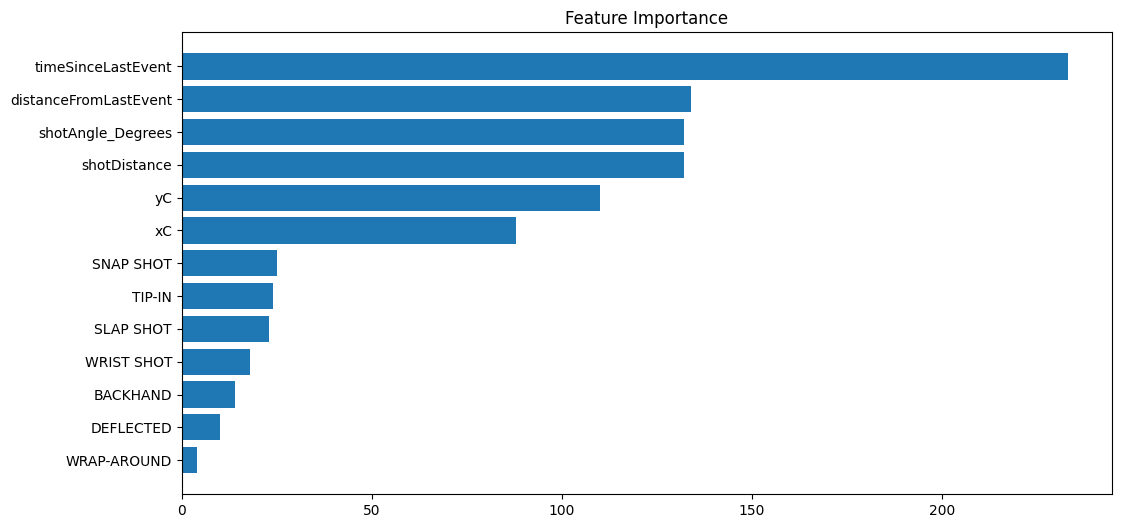

In [412]:
#Feature importance
from sklearn.inspection import permutation_importance
feature_importance = bst.get_score(importance_type='weight')

# Convert to array for plotting
sorted_idx = np.argsort(list(feature_importance.values()))
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), np.array(list(feature_importance.values()))[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(list(feature_importance.keys()))[sorted_idx])
plt.title('Feature Importance')
plt.show()

Once Model is built, then since we are trying to find best forward lines, Group by player1, player2, player3. Sum their expected goals. Take top 15.

In [413]:
pred_varBoost= pbp[['timeSinceLastEvent','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT']]
dtest=xgb.DMatrix(pred_varBoost)
xG=bst.predict(dtest)
pbp['xG']=xG

In [417]:
pbp.head()

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,...,BACKHAND,DEFLECTED,SLAP SHOT,SNAP SHOT,TIP-IN,WRAP-AROUND,WRIST SHOT,Description,Type,xG
6,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,BRAYDEN POINT,STEVEN STAMKOS,...,0,0,0,0,0,0,1,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",WRIST SHOT,0.104167
40,Off,T.B,T.B,NSH,SHOT,PHILIP TOMASINO,RYAN O'REILLY,LUKE EVANGELISTA,BRAYDEN POINT,STEVEN STAMKOS,...,0,0,0,0,0,0,1,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",WRIST SHOT,0.067928
41,Off,T.B,T.B,NSH,GOAL,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,BRAYDEN POINT,STEVEN STAMKOS,...,0,0,1,0,0,0,0,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",SLAP SHOT,0.062924
44,Neu,T.B,T.B,NSH,MISS,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,...,0,0,0,0,0,0,1,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",WRIST SHOT,0.055098
47,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,...,0,0,0,1,0,0,0,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",SNAP SHOT,0.081574


Alright time to group by forward lines. 

In [419]:
# Step 1: Create separate columns for each player based on Ev_Team
pbp['Player1'] = pbp.apply(lambda row: row['awayPlayer1'] if row['Ev_Team'] == row['Away_Team'] else row['homePlayer1'], axis=1)
pbp['Player2'] = pbp.apply(lambda row: row['awayPlayer2'] if row['Ev_Team'] == row['Away_Team'] else row['homePlayer2'], axis=1)
pbp['Player3'] = pbp.apply(lambda row: row['awayPlayer3'] if row['Ev_Team'] == row['Away_Team'] else row['homePlayer3'], axis=1)

# Step 2: Group by the three player columns and sum the xG
xg_ForwardLine = pbp.groupby(['Player1', 'Player2', 'Player3'])['xG'].sum().reset_index()

Moment of truth

In [420]:
xg_ForwardLine=xg_ForwardLine.sort_values(by='xG', ascending=False)
xg_ForwardLine.head(15)

,Player1,Player2,Player3,xG
9527,VINCENT TROCHECK,ARTEMI PANARIN,ALEXIS LAFRENIÈRE,42.279934
3225,GUSTAV NYQUIST,RYAN O'REILLY,FILIP FORSBERG,38.728416
827,ANZE KOPITAR,ADRIAN KEMPE,QUINTON BYFIELD,36.262341
1298,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,34.795593
3987,JOE PAVELSKI,ROOPE HINTZ,JASON ROBERTSON,33.306087
6548,NICK SUZUKI,COLE CAUFIELD,JURAJ SLAFKOVSKY,32.026630
6299,NATHAN MACKINNON,VALERI NICHUSHKIN,MIKKO RANTANEN,31.084497
6284,NATHAN MACKINNON,MIKKO RANTANEN,JONATHAN DROUIN,30.043619
9572,VINCENT TROCHECK,MIKA ZIBANEJAD,ARTEMI PANARIN,29.454103
7258,PHILLIP DANAULT,TREVOR MOORE,KEVIN FIALA,28.961668


AWESOME. The above gives the best offensive lines in hockey by xG For. 

Now I want to calculate the best defensive lines in hockey by xG Against.

In [421]:
 #Step 1: Create separate columns for each opposing player based on Ev_Team
pbp['Opp_Player1'] = pbp.apply(lambda row: row['homePlayer1'] if row['Ev_Team'] == row['Away_Team'] else row['awayPlayer1'], axis=1)
pbp['Opp_Player2'] = pbp.apply(lambda row: row['homePlayer2'] if row['Ev_Team'] == row['Away_Team'] else row['awayPlayer2'], axis=1)
pbp['Opp_Player3'] = pbp.apply(lambda row: row['homePlayer3'] if row['Ev_Team'] == row['Away_Team'] else row['awayPlayer3'], axis=1)

# Step 2: Group by the three opposing player columns and sum the xG
xg_Against = pbp.groupby(['Opp_Player1', 'Opp_Player2', 'Opp_Player3'])['xG'].sum().reset_index()

# Step 3: Sort the results by xG Against in descending order to find the highest xG Against lines
xg_Against = xg_Against.sort_values(by='xG', ascending=False)

In [425]:
xg_Against=xg_Against.sort_values(by='xG', ascending=True)
xg_Against.tail(90)

,Opp_Player1,Opp_Player2,Opp_Player3,xG
7805,NICK SCHMALTZ,ALEX KERFOOT,CLAYTON KELLER,7.573820
6135,LOGAN STANKOVEN,WYATT JOHNSTON,JAMIE BENN,7.580680
3372,DYLAN COZENS,JJ PETERKA,ZACH BENSON,7.604092
2107,CHANDLER STEPHENSON,PAUL COTTER,MARK STONE,7.639775
3961,GABRIEL VILARDI,MARK SCHEIFELE,NIKOLAJ EHLERS,7.669556
...,...,...,...,...
201,ADAM LOWRY,MASON APPLETON,NINO NIEDERREITER,25.348331
11312,TYLER SEGUIN,MATT DUCHENE,MASON MARCHMENT,28.734850
7902,NICK SUZUKI,COLE CAUFIELD,JURAJ SLAFKOVSKY,30.233604
4020,GUSTAV NYQUIST,RYAN O'REILLY,FILIP FORSBERG,31.200027
